In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 100
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                lr_bp=0.0001, batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, early_stop_thres=50, 
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                verbose=True, val_ratio=0.2, random_state=random_state)
model.fit(train_x, train_y, sample_weight=np.random.uniform(0, 1, size=(train_x.shape[0], 1)))

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.03521, val loss: 0.03572
Main effects training epoch: 2, train loss: 0.02014, val loss: 0.02092
Main effects training epoch: 3, train loss: 0.01960, val loss: 0.02055
Main effects training epoch: 4, train loss: 0.01937, val loss: 0.02050
Main effects training epoch: 5, train loss: 0.01971, val loss: 0.02044
Main effects training epoch: 6, train loss: 0.01935, val loss: 0.02037
Main effects training epoch: 7, train loss: 0.01879, val loss: 0.02034
Main effects training epoch: 8, train loss: 0.01924, val loss: 0.02022
Main effects training epoch: 9, train loss: 0.01952, val loss: 0.02017
Main effects training epoch: 10, train loss: 0.01893, val loss: 0.02004
Main effects training epoch: 11, train loss: 0.01882, val loss: 0.01984
Main effects training epoch: 12, train loss: 0.01888, val loss: 0.01966
Main effects training e

Main effects training epoch: 114, train loss: 0.01131, val loss: 0.01237
Main effects training epoch: 115, train loss: 0.01127, val loss: 0.01235
Main effects training epoch: 116, train loss: 0.01117, val loss: 0.01240
Main effects training epoch: 117, train loss: 0.01136, val loss: 0.01239
Main effects training epoch: 118, train loss: 0.01147, val loss: 0.01237
Main effects training epoch: 119, train loss: 0.01130, val loss: 0.01235
Main effects training epoch: 120, train loss: 0.01121, val loss: 0.01233
Main effects training epoch: 121, train loss: 0.01111, val loss: 0.01234
Main effects training epoch: 122, train loss: 0.01123, val loss: 0.01239
Main effects training epoch: 123, train loss: 0.01134, val loss: 0.01242
Main effects training epoch: 124, train loss: 0.01104, val loss: 0.01231
Main effects training epoch: 125, train loss: 0.01120, val loss: 0.01246
Main effects training epoch: 126, train loss: 0.01120, val loss: 0.01237
Main effects training epoch: 127, train loss: 0.011

Main effects training epoch: 227, train loss: 0.01081, val loss: 0.01208
Main effects training epoch: 228, train loss: 0.01087, val loss: 0.01213
Main effects training epoch: 229, train loss: 0.01066, val loss: 0.01194
Main effects training epoch: 230, train loss: 0.01064, val loss: 0.01191
Main effects training epoch: 231, train loss: 0.01088, val loss: 0.01187
Main effects training epoch: 232, train loss: 0.01079, val loss: 0.01189
Main effects training epoch: 233, train loss: 0.01083, val loss: 0.01187
Main effects training epoch: 234, train loss: 0.01093, val loss: 0.01220
Main effects training epoch: 235, train loss: 0.01068, val loss: 0.01197
Main effects training epoch: 236, train loss: 0.01069, val loss: 0.01192
Main effects training epoch: 237, train loss: 0.01058, val loss: 0.01189
Main effects training epoch: 238, train loss: 0.01078, val loss: 0.01187
Main effects training epoch: 239, train loss: 0.01097, val loss: 0.01206
Main effects training epoch: 240, train loss: 0.010

Interaction training epoch: 84, train loss: 0.00517, val loss: 0.00519
Interaction training epoch: 85, train loss: 0.00497, val loss: 0.00518
Interaction training epoch: 86, train loss: 0.00489, val loss: 0.00521
Interaction training epoch: 87, train loss: 0.00501, val loss: 0.00517
Interaction training epoch: 88, train loss: 0.00492, val loss: 0.00521
Interaction training epoch: 89, train loss: 0.00506, val loss: 0.00522
Interaction training epoch: 90, train loss: 0.00483, val loss: 0.00511
Interaction training epoch: 91, train loss: 0.00506, val loss: 0.00512
Interaction training epoch: 92, train loss: 0.00492, val loss: 0.00512
Interaction training epoch: 93, train loss: 0.00494, val loss: 0.00518
Interaction training epoch: 94, train loss: 0.00489, val loss: 0.00504
Interaction training epoch: 95, train loss: 0.00489, val loss: 0.00503
Interaction training epoch: 96, train loss: 0.00488, val loss: 0.00499
Interaction training epoch: 97, train loss: 0.00481, val loss: 0.00502
Intera

Interaction training epoch: 199, train loss: 0.00263, val loss: 0.00282
Interaction training epoch: 200, train loss: 0.00263, val loss: 0.00289
Interaction training epoch: 201, train loss: 0.00258, val loss: 0.00288
Interaction training epoch: 202, train loss: 0.00265, val loss: 0.00285
Interaction training epoch: 203, train loss: 0.00261, val loss: 0.00281
Interaction training epoch: 204, train loss: 0.00258, val loss: 0.00276
Interaction training epoch: 205, train loss: 0.00260, val loss: 0.00279
Interaction training epoch: 206, train loss: 0.00259, val loss: 0.00277
Interaction training epoch: 207, train loss: 0.00272, val loss: 0.00294
Interaction training epoch: 208, train loss: 0.00252, val loss: 0.00272
Interaction training epoch: 209, train loss: 0.00258, val loss: 0.00276
Interaction training epoch: 210, train loss: 0.00262, val loss: 0.00274
Interaction training epoch: 211, train loss: 0.00247, val loss: 0.00277
Interaction training epoch: 212, train loss: 0.00256, val loss: 

Interaction training epoch: 313, train loss: 0.00221, val loss: 0.00249
Interaction training epoch: 314, train loss: 0.00217, val loss: 0.00241
Interaction training epoch: 315, train loss: 0.00212, val loss: 0.00245
Interaction training epoch: 316, train loss: 0.00216, val loss: 0.00243
Interaction training epoch: 317, train loss: 0.00217, val loss: 0.00241
Interaction training epoch: 318, train loss: 0.00218, val loss: 0.00246
Interaction training epoch: 319, train loss: 0.00223, val loss: 0.00246
Interaction training epoch: 320, train loss: 0.00223, val loss: 0.00248
Interaction training epoch: 321, train loss: 0.00216, val loss: 0.00247
Interaction training epoch: 322, train loss: 0.00217, val loss: 0.00244
Interaction training epoch: 323, train loss: 0.00214, val loss: 0.00237
Interaction training epoch: 324, train loss: 0.00212, val loss: 0.00241
Interaction training epoch: 325, train loss: 0.00218, val loss: 0.00242
Interaction training epoch: 326, train loss: 0.00214, val loss: 

Interaction training epoch: 427, train loss: 0.00204, val loss: 0.00233
Interaction training epoch: 428, train loss: 0.00202, val loss: 0.00231
Interaction training epoch: 429, train loss: 0.00203, val loss: 0.00236
Interaction training epoch: 430, train loss: 0.00203, val loss: 0.00238
Interaction training epoch: 431, train loss: 0.00209, val loss: 0.00236
Interaction training epoch: 432, train loss: 0.00200, val loss: 0.00232
Interaction training epoch: 433, train loss: 0.00200, val loss: 0.00232
Interaction training epoch: 434, train loss: 0.00201, val loss: 0.00232
Interaction training epoch: 435, train loss: 0.00201, val loss: 0.00237
Interaction training epoch: 436, train loss: 0.00206, val loss: 0.00238
Interaction training epoch: 437, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 438, train loss: 0.00204, val loss: 0.00241
Interaction training epoch: 439, train loss: 0.00203, val loss: 0.00239
Interaction training epoch: 440, train loss: 0.00205, val loss: 

Fine tuning epoch: 70, train loss: 0.00207, val loss: 0.00220
Fine tuning epoch: 71, train loss: 0.00217, val loss: 0.00234
Fine tuning epoch: 72, train loss: 0.00210, val loss: 0.00219
Fine tuning epoch: 73, train loss: 0.00209, val loss: 0.00223
Fine tuning epoch: 74, train loss: 0.00213, val loss: 0.00225
Fine tuning epoch: 75, train loss: 0.00210, val loss: 0.00223
Fine tuning epoch: 76, train loss: 0.00209, val loss: 0.00224
Fine tuning epoch: 77, train loss: 0.00219, val loss: 0.00226
Fine tuning epoch: 78, train loss: 0.00210, val loss: 0.00227
Fine tuning epoch: 79, train loss: 0.00209, val loss: 0.00225
Fine tuning epoch: 80, train loss: 0.00211, val loss: 0.00225
Fine tuning epoch: 81, train loss: 0.00208, val loss: 0.00224
Fine tuning epoch: 82, train loss: 0.00211, val loss: 0.00224
Fine tuning epoch: 83, train loss: 0.00216, val loss: 0.00229
Fine tuning epoch: 84, train loss: 0.00221, val loss: 0.00230
Fine tuning epoch: 85, train loss: 0.00209, val loss: 0.00220
Fine tun

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

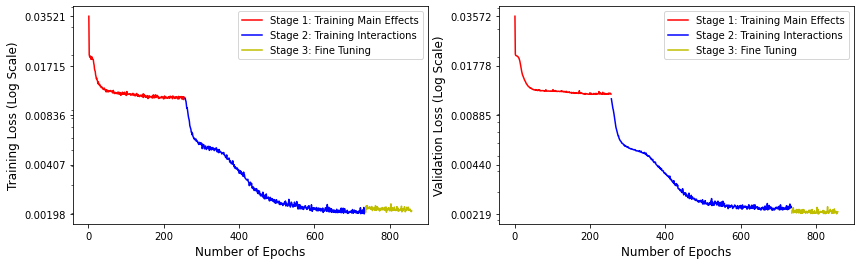

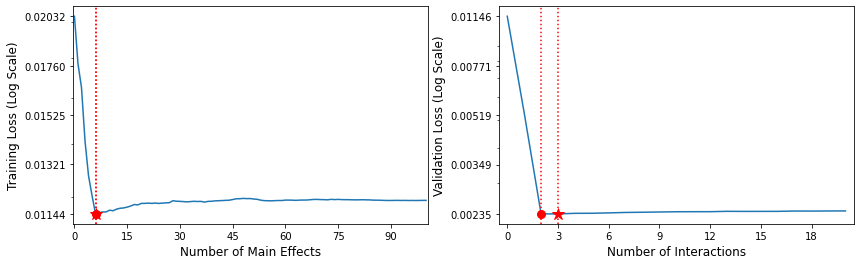

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

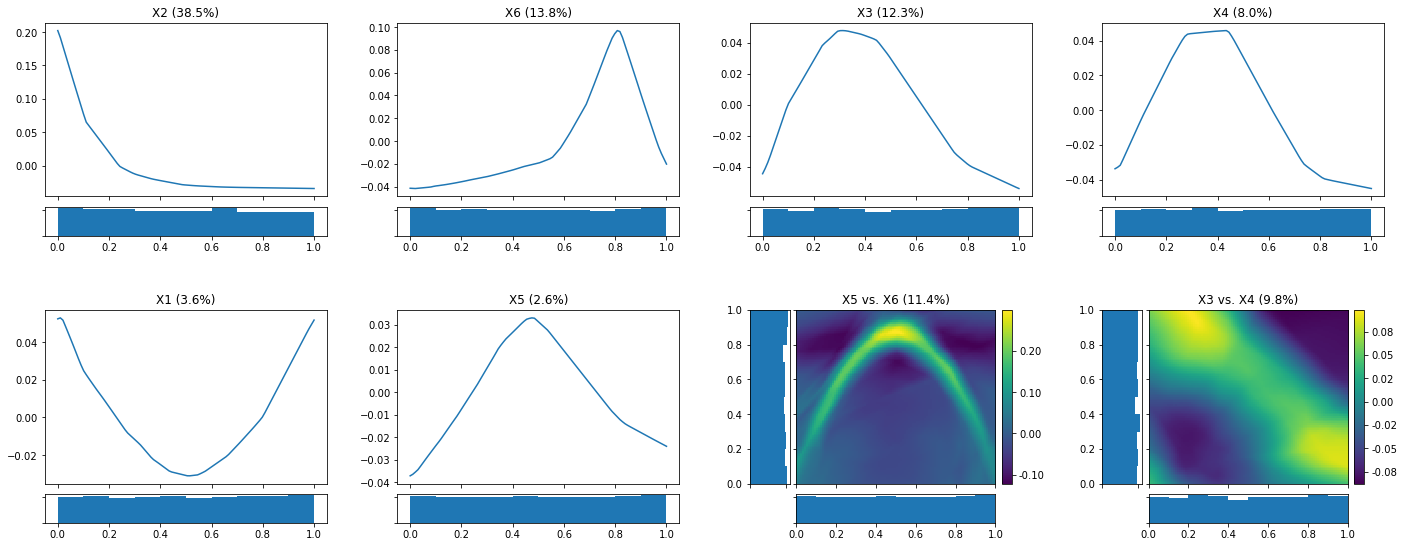

In [6]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')

Feature Importance

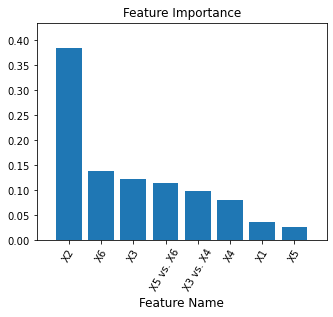

In [7]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [8]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

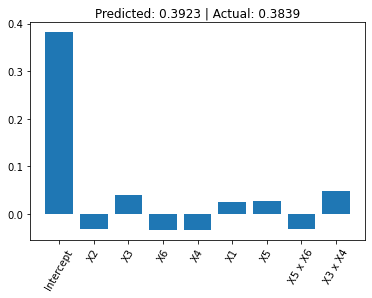

In [9]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

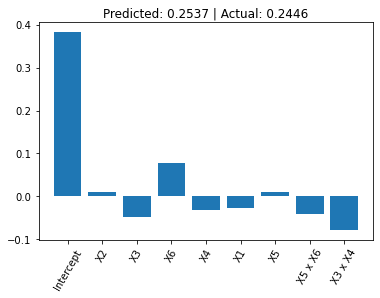

In [10]:
local_visualize(data_dict_local[1], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [11]:
model.save(folder="./", name="model_saved")

In [12]:
## The reloaded model should not be refit again
modelnew = GAMINet(meta_info={})
modelnew.load(folder="./", name="model_saved")

In [14]:
pred_train = modelnew.predict(tr_x)
pred_val = modelnew.predict(val_x)
pred_test = modelnew.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[1.02396 1.05447 1.03119]
